In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os
from tqdm import tqdm
from seaborn import set_style
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.api import SARIMAX
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import xgboost as xgb

set_style("whitegrid")
#Import the csv file
dfhl=pd.read_csv('dfhl.csv')
dfhl.time=pd.to_datetime(dfhl.time)
dfhl.open=dfhl.open.astype(float);dfhl.volume=dfhl.volume.astype(float);dfhl.MACD=dfhl.MACD.astype(float)
dfhl.MACD_Hist=dfhl.MACD_Hist.astype(float);dfhl.MACD_Signal=dfhl.MACD_Signal.astype(float)
dfhl

,time,open,volume,MACD,MACD_Hist,MACD_Signal,high,low
0,2023-05-19 15:59:00,418.96,2143843.0,0.1287,0.0285,0.1002,418.960,418.95
1,2023-05-19 15:58:00,418.95,1261060.0,0.1228,0.0298,0.0930,418.960,418.87
2,2023-05-19 15:57:00,418.87,1400980.0,0.1146,0.0290,0.0856,418.960,418.87
3,2023-05-19 15:56:00,418.91,661219.0,0.1105,0.0322,0.0784,418.960,418.87
4,2023-05-19 15:55:00,418.89,758281.0,0.0997,0.0294,0.0703,418.960,418.82
...,...,...,...,...,...,...,...,...
6235,2023-04-28 09:34:00,411.98,222984.0,0.1197,0.0466,0.0732,414.750,411.98
6236,2023-04-28 09:33:00,412.14,188445.0,0.1086,0.0471,0.0615,414.750,411.95
6237,2023-04-28 09:32:00,411.95,282485.0,0.0766,0.0269,0.0497,414.750,411.90
6238,2023-04-28 09:31:00,411.90,306992.0,0.0540,0.0109,0.0430,414.695,411.49


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


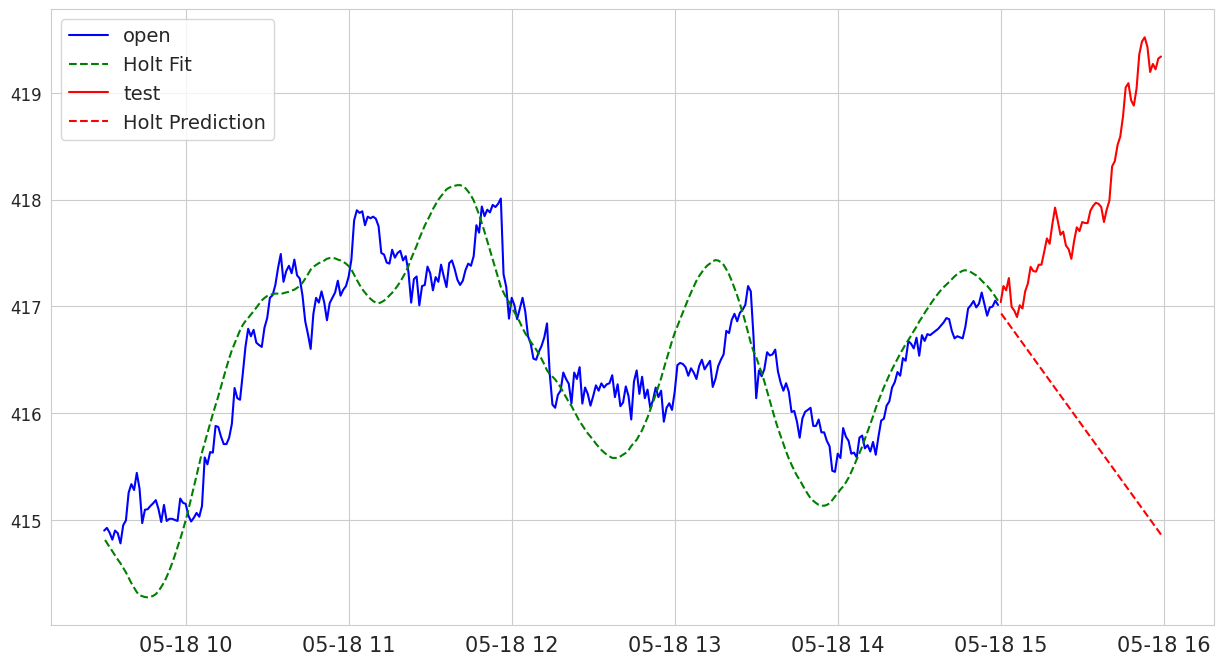

In [ ]:
#Try Holt prediction for the last hour on 5/18 with trainning set from 9:30 am to 3 pm. Choose sample parameters.

exp_smooth=Holt(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & 
                         (dfhl.time<pd.Timestamp(2023,5,18,15))].copy().open.values).fit(smoothing_level=0.04,
                                                                                  smoothing_trend=0.2,
                                                                                  optimized=False)
plt.figure(figsize=(15,8))
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,18,15))].open,'b',label='open')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,18,15))].time,
         exp_smooth.fittedvalues,'g--',label='Holt Fit')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,15)) & (dfhl.time<pd.Timestamp(2023,5,19))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,15)) & (dfhl.time<pd.Timestamp(2023,5,19))].open,'r',label='test')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,15)) & (dfhl.time<pd.Timestamp(2023,5,19))].time,
         exp_smooth.forecast(60),'r--',label='Holt Prediction')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

In [ ]:
#With the 2-hours windows idea, conduct a grid search for alpha and beta (8mins).

train_series=dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,18,15))].copy().open
train_values=train_series.values
holt_predict_high=np.zeros((20,20,211));holt_predict_low=np.zeros((20,20,211))
holt_mae_high=np.zeros((20,20));holt_mae_low=np.zeros((20,20))
for j in tqdm(range(20), desc="j"):
    for k in tqdm(range(20), desc="k"):
        for i in range(211):
            holt_smooth=Holt(train_values[i:i+120]).fit(smoothing_level=0.01*(j+1),
                                        smoothing_trend=0.01*(k+1),
                                        optimized=False)
            holt_predict_high[j,k,i]=holt_smooth.forecast(60).max();holt_predict_low[j,k,i]=holt_smooth.forecast(60).min()
        holt_mae_high[j,k] = mean_absolute_error(holt_predict_high[j,k], dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) &
                                                      (dfhl.time<=pd.Timestamp(2023,5,18,15))].high)
        holt_mae_low[j,k] = mean_absolute_error(holt_predict_low[j,k], dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) &
                                                      (dfhl.time<=pd.Timestamp(2023,5,18,15))].low)

holthighindex=np.unravel_index(np.argmin(holt_mae_high),(20,20))
holtlowindex=np.unravel_index(np.argmin(holt_mae_low),(20,20))
print(holthighindex);print(holtlowindex)

j: 100%|██████████| 20/20 [08:06<00:00, 24.32s/it]

(3, 1)
(1, 2)


In [ ]:
#Hiothighindex and holtlowindex are (3,1) and (1,2)
print("For high value, alpha=",0.01*(holthighindex[0]+1),"and beta=",0.01*(holthighindex[1]+1))
print("For low value, alpha=",0.01*(holtlowindex[0]+1),"and beta=",0.01*(holtlowindex[1]+1))
print('MAE_HIGH:',holt_mae_high[holthighindex[0],holthighindex[1]])
print('MAE_LOW:',holt_mae_low[holtlowindex[0],holtlowindex[1]])

For high value, alpha= 0.04 and beta= 0.02
For low value, alpha= 0.02 and beta= 0.03
MAE_HIGH: 1.3768917368407934
MAE_LOW: 1.2660164912777465


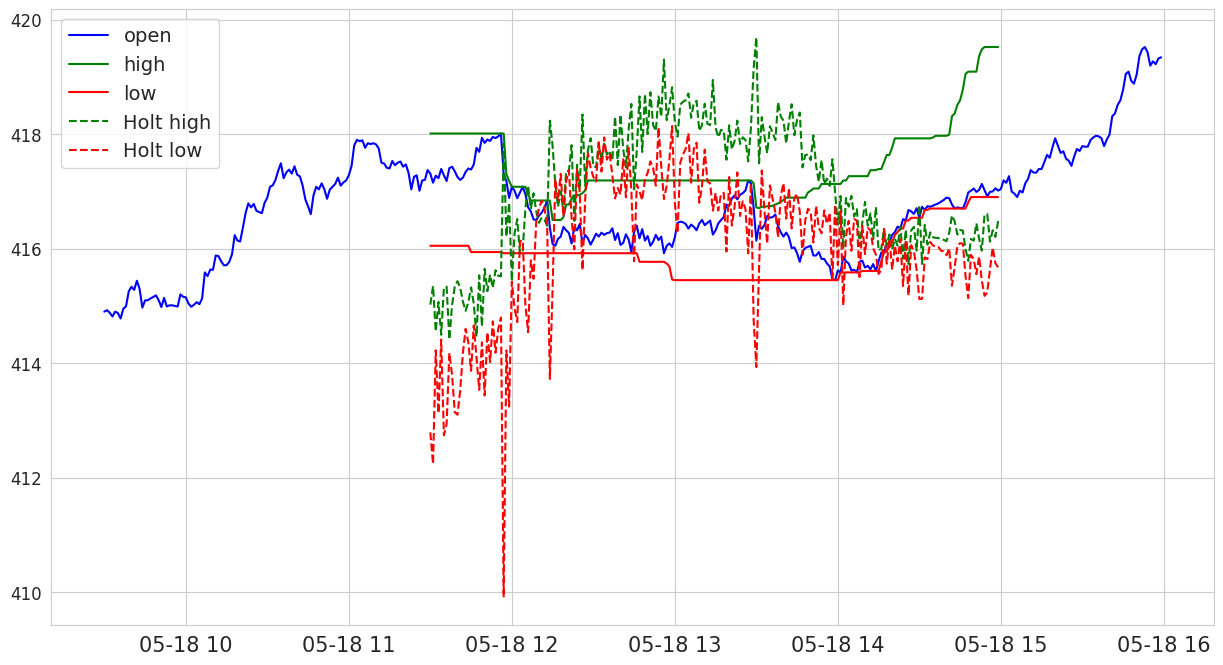

In [ ]:
#Draw Holt predictions for high/low 
plt.figure(figsize=(15,8))
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].open,'b',label='open')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].high,'g',label='high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].low,'r',label='low')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         holt_predict_high[3,1],'g--',label='Holt high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         holt_predict_low[1,2],'r--',label='Holt low')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

<Figure size 1500x800 with 0 Axes>

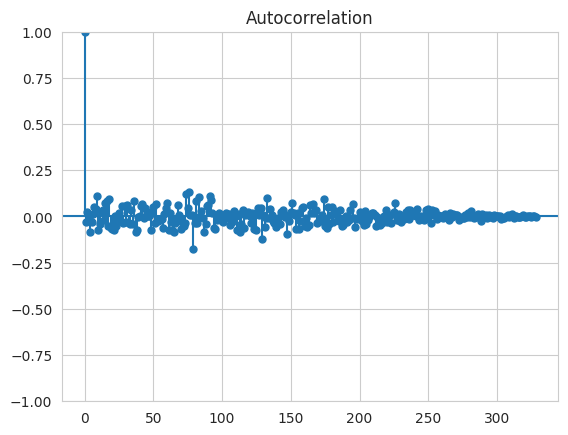

In [ ]:
#Try ARIMA (SARIMAX) model. Choose d=1

train_series=dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,18,15))].copy().open
train_values=train_series.values
plt.figure(figsize=(15,8))
sm.graphics.tsa.plot_acf(train_series.diff().values[1:],alpha=None,lags=328)
plt.show()


In [ ]:
#Conduct a grid search for p and q (14mins).
arima_predict_high=np.zeros((4,4,211))
arima_predict_low=np.zeros((4,4,211))
arima_mae_high=np.zeros((4,4))
arima_mae_low=np.zeros((4,4))

for j in tqdm(range(4),desc='j'):
    for k in tqdm(range(4),desc='k'):
        for i in tqdm(range(211),desc='i'):
            arima=SARIMAX(train_values[i:i+120],order=(j,1,k)).fit(maxiter=500)
            arima_predict_high[j,k,i]=arima.forecast(60).max();arima_predict_low[j,k,i]=arima.forecast(60).min()
        arima_mae_high[j,k] = mean_absolute_error(arima_predict_high[j,k], dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) &
                                                      (dfhl.time<=pd.Timestamp(2023,5,18,15))].high)
        arima_mae_low[j,k] = mean_absolute_error(arima_predict_low[j,k], dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) &
                                                      (dfhl.time<=pd.Timestamp(2023,5,18,15))].low)

arimahighindex=np.unravel_index(np.argmin(arima_mae_high),(4,4))
arimalowindex=np.unravel_index(np.argmin(arima_mae_low),(4,4))
print(arimahighindex);print(arimalowindex)

Streaming output truncated to the last 5000 lines.

i:  11%|█         | 23/211 [00:00<00:05, 36.85it/s]

i:  13%|█▎        | 28/211 [00:00<00:04, 39.43it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


i:  15%|█▌        | 32/211 [00:00<00:04, 37.13it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


i:  17%|█▋        | 36/211 [00:01<00:04, 35.66it/s]

i:  19%|█▉        | 41/211 [00:01<00:04, 37.71it/s]

i:  22%|██▏       | 46/211 [00:01<00:04, 39.51it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Li

(2, 2)
(2, 3)


In [ ]:
#arimahighindex and arimalowindex are (2,2) and (2,3)
print("For high value, p=",arimahighindex[0],"and q=",arimahighindex[1])
print("For low value, p=",arimalowindex[0],"and q=",arimalowindex[1])
print('MAE_HIGH:',arima_mae_high[arimahighindex[0],arimahighindex[1]])
print('MAE_LOW:',arima_mae_low[arimalowindex[0],arimalowindex[1]])

For high value, p= 2 and q= 2
For low value, p= 2 and q= 3
MAE_HIGH: 1.2089624030925281
MAE_LOW: 1.1333682855495828


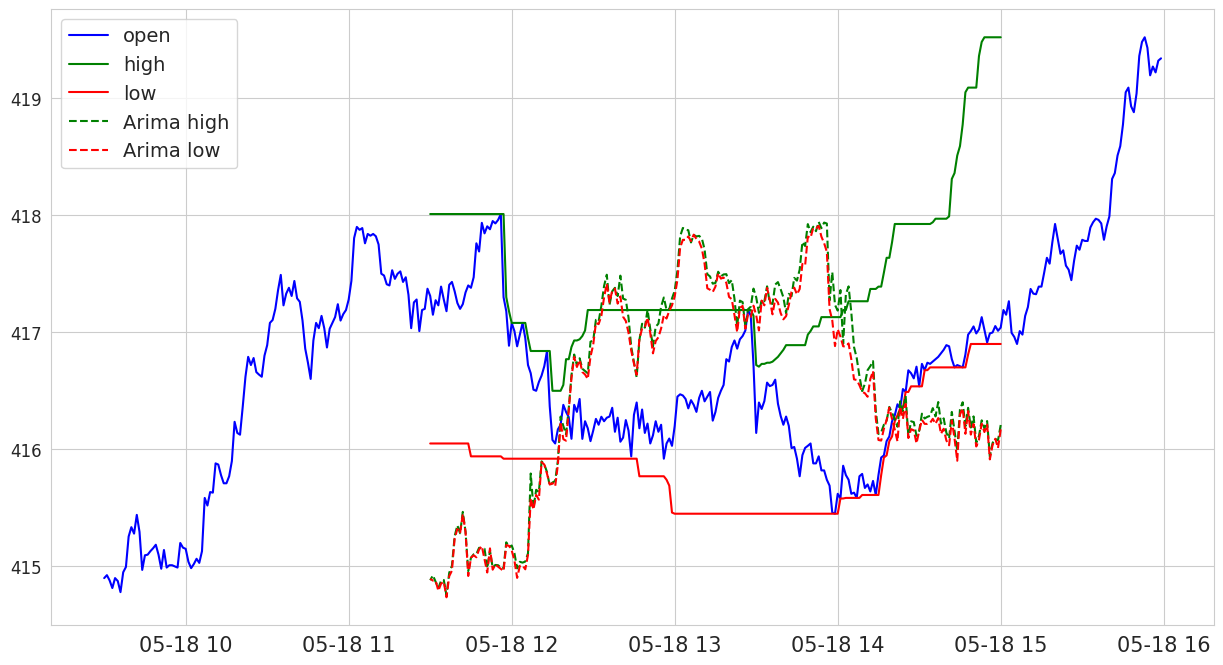

In [ ]:
#Draw Arima predictions for high/low
plt.figure(figsize=(15,8))
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].open,'b',label='open')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].high,'g',label='high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].low,'r',label='low')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         arima_predict_high[2,2],'g--',label='Arima high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         arima_predict_low[2,3],'r--',label='Arima low')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

In [ ]:
#Use Linear Regression.

X_train=pd.read_csv('X_train.csv').copy()
Y_train=pd.read_csv('Y_train.csv').copy()
X_test=pd.read_csv('X_test.csv').copy()
Y_test=pd.read_csv('Y_test.csv').copy()

linearh=LinearRegression().fit(X_train,Y_train['High'])
linearl=LinearRegression().fit(X_train,Y_train['Low'])
linear_mae_high=mean_absolute_error(linearh.predict(X_test),Y_test['High'])
linear_mae_low=mean_absolute_error(linearl.predict(X_test),Y_test['Low'])

print('MAE_HIGH:',linear_mae_high)
print('MAE_LOW:',linear_mae_low)


MAE_HIGH: 0.6714075232109371
MAE_LOW: 0.47605331180088833


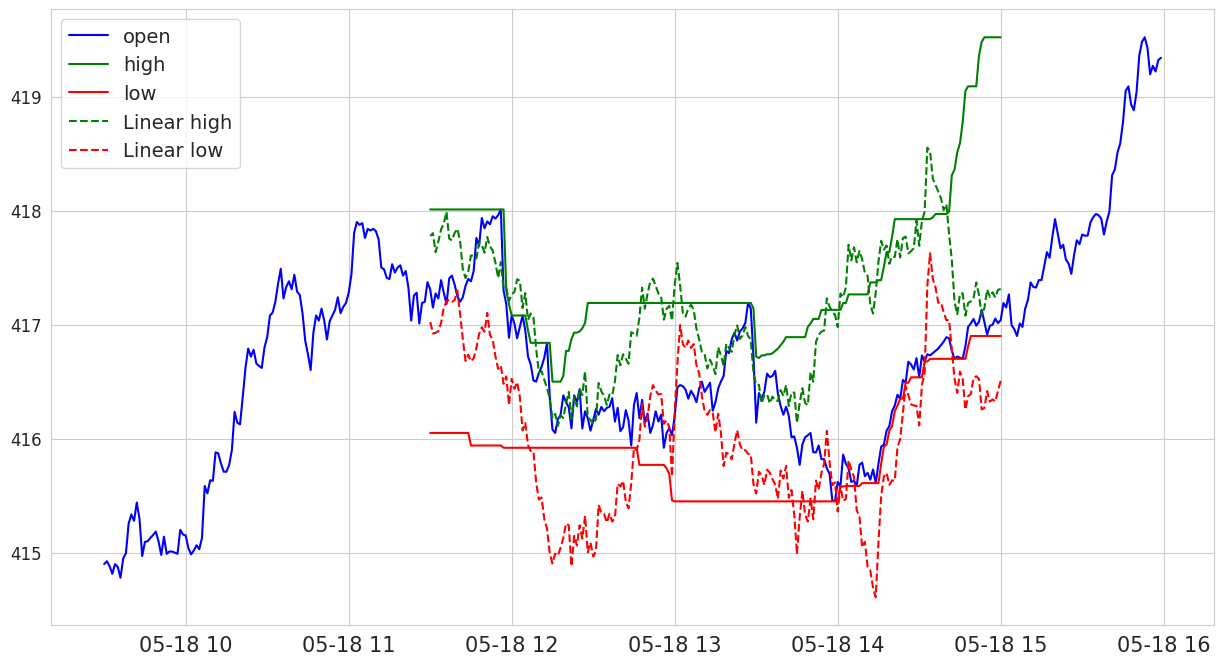

In [ ]:
#Draw LinearRegression predictions for high/low

plt.figure(figsize=(15,8))
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].open,'b',label='open')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].high,'g',label='high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].low,'r',label='low')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         linearh.predict(X_test),'g--',label='Linear high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         linearl.predict(X_test),'r--',label='Linear low')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

In [ ]:
#Use Ridge Linear Regression. Conduct a grid search for alpha from 0 to 0.05. (3min)

X_train=pd.read_csv('X_train.csv').copy()
Y_train=pd.read_csv('Y_train.csv').copy()
X_test=pd.read_csv('X_test.csv').copy()
Y_test=pd.read_csv('Y_test.csv').copy()

ridge_predict_high=np.zeros(500)
ridge_predict_low=np.zeros(500)
ridge_mae_high=np.zeros(500)
ridge_mae_low=np.zeros(500)

for i in tqdm(range(0,500),desc='i'):
    ridgeh=Ridge(alpha=0.0001*(i+1)).fit(X_train,Y_train['High'])
    ridgel=Ridge(alpha=0.0001*(i+1)).fit(X_train,Y_train['Low'])
    ridge_mae_high[i]=mean_absolute_error(ridgeh.predict(X_test),Y_test['High'])
    ridge_mae_low[i]=mean_absolute_error(ridgel.predict(X_test),Y_test['Low'])
ridgehighindex=np.argmin(ridge_mae_high)
ridgelowindex=np.argmin(ridge_mae_low)

print('alpha for high=',0.0001*(ridgehighindex+1))
print('alpha for low=',0.0001*(ridgelowindex+1))

i:   0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.24895e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.24895e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
i:   0%|          | 1/500 [00:00<02:00,  4.14it/s]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.49539e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.49539e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True

alpha for high= 0.0198
alpha for low= 0.0


In [ ]:
print('MAE_HIGH:',ridge_mae_high[ridgehighindex]);print('MAE_LOW:',ridge_mae_low[ridgelowindex])

MAE_HIGH: 0.624503535719235
MAE_LOW: 0.5323171335486889


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.38646e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.00376e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


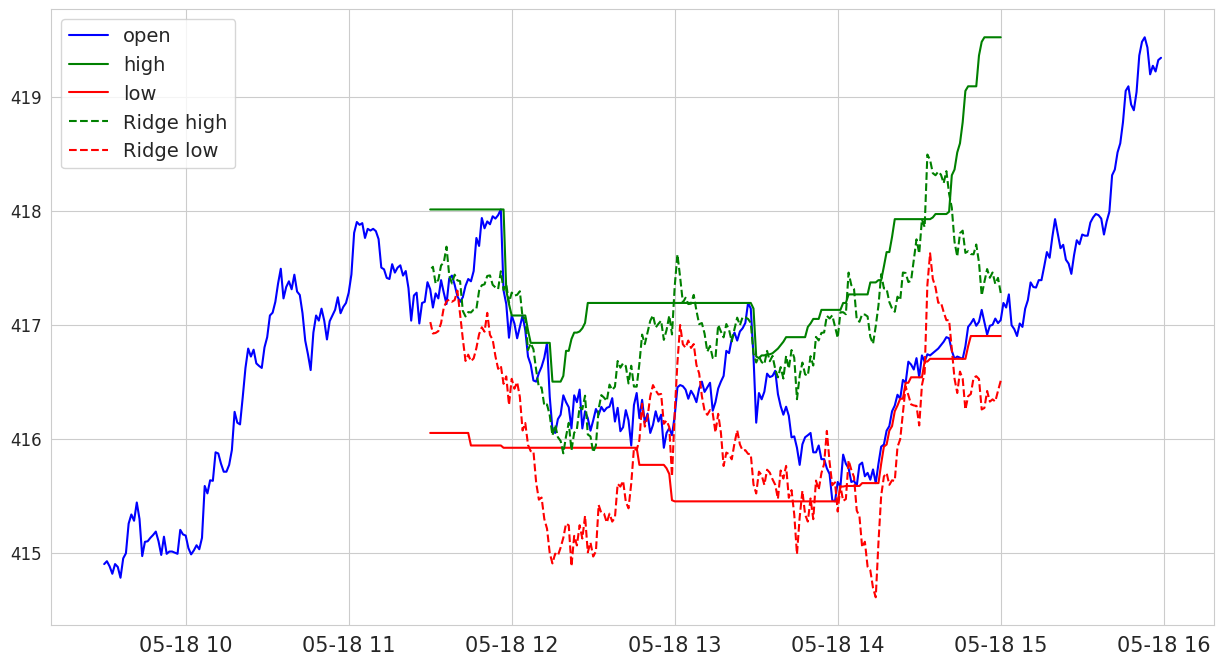

In [ ]:
#Draw Ridge predictions for high/low. Alpha for high/low = 0.0199/0.0001 
ridgeh=Ridge(alpha=0.0199).fit(X_train,Y_train['High'])
ridgel=Ridge(alpha=0).fit(X_train,Y_train['Low'])
plt.figure(figsize=(15,8))
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].open,'b',label='open')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].high,'g',label='high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].low,'r',label='low')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         ridgeh.predict(X_test),'g--',label='Ridge high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         ridgel.predict(X_test),'r--',label='Ridge low')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

In [ ]:
#Use Lasso Linear Regression. Conduct a grid search for alpha from 0 to 0.2 (>5min).

X_train=pd.read_csv('X_train.csv').copy()
Y_train=pd.read_csv('Y_train.csv').copy()
X_test=pd.read_csv('X_test.csv').copy()
Y_test=pd.read_csv('Y_test.csv').copy()

lasso_predict_high=np.zeros(50)
lasso_predict_low=np.zeros(50)
lasso_mae_high=np.zeros(50)
lasso_mae_low=np.zeros(50)

for i in tqdm(range(0,50),desc='i'):
    lassoh=Lasso(alpha=0.004*(i+1),max_iter=100000).fit(X_train,Y_train['High'])
    lassol=Lasso(alpha=0.004*(i+1),max_iter=100000).fit(X_train,Y_train['Low'])
    lasso_mae_high[i]=mean_absolute_error(lassoh.predict(X_test),Y_test['High'])
    lasso_mae_low[i]=mean_absolute_error(lassol.predict(X_test),Y_test['Low'])
lassohighindex=np.argmin(lasso_mae_high)
lassolowindex=np.argmin(lasso_mae_low)
print('alpha for high=',0.004*(lassohighindex+1))
print('alpha for low=',0.004*(lassolowindex+1))

i: 100%|██████████| 50/50 [08:41<00:00, 10.44s/it]

alpha for high= 0.004
alpha for low= 0.02


In [ ]:
print('MAE_HIGH:',lasso_mae_high[lassohighindex]);print('MAE_LOW:',lasso_mae_low[lassolowindex])

MAE_HIGH: 0.6329904574169518
MAE_LOW: 0.5220625574284896


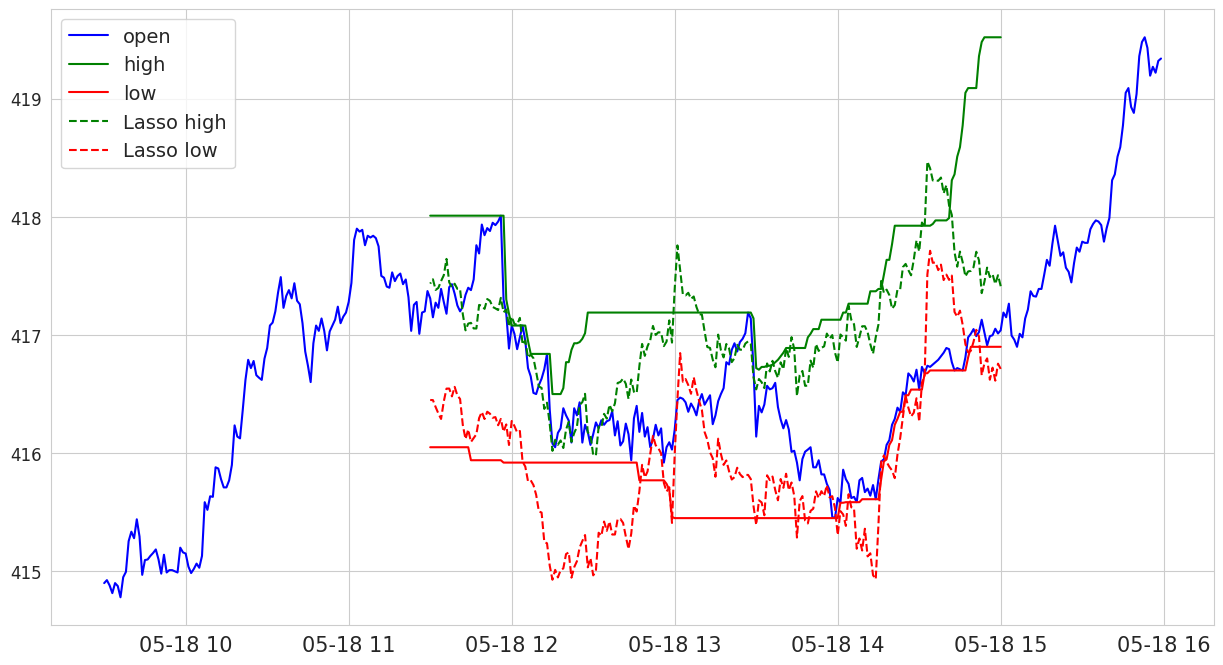

In [ ]:
#Draw Lasso predictions for high/low. Alpha for high/low = 0.004/0.02 
lassoh=Lasso(alpha=0.004,max_iter=100000).fit(X_train,Y_train['High'])
lassol=Lasso(alpha=0.02,max_iter=100000).fit(X_train,Y_train['Low'])
plt.figure(figsize=(15,8))
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].open,'b',label='open')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].high,'g',label='high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].low,'r',label='low')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         lassoh.predict(X_test),'g--',label='Lasso high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         lassol.predict(X_test),'r--',label='Lasso low')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

In [ ]:
#Use DecisionTree and RandomForest (4min)
X_train=pd.read_csv('X_train.csv').copy()
Y_train=pd.read_csv('Y_train.csv').copy()
X_test=pd.read_csv('X_test.csv').copy()
Y_test=pd.read_csv('Y_test.csv').copy()

treeh=DecisionTreeRegressor().fit(X_train,Y_train['High'])
treel=DecisionTreeRegressor().fit(X_train,Y_train['Low'])
tree_mae_high=mean_absolute_error(treeh.predict(X_test),Y_test['High'])
tree_mae_low=mean_absolute_error(treel.predict(X_test),Y_test['Low'])

rfh=RandomForestRegressor(random_state=1).fit(X_train,Y_train['High'])
rfl=RandomForestRegressor(random_state=1).fit(X_train,Y_train['Low'])
rf_mae_high=mean_absolute_error(rfh.predict(X_test),Y_test['High'])
rf_mae_low=mean_absolute_error(rfl.predict(X_test),Y_test['Low'])

print('TREE_MAE_HIGH:',tree_mae_high)
print('TREE_MAE_LOW:',tree_mae_low)
print('RF_MAE_HIGH:',rf_mae_high)
print('RF_MAE_LOW:',rf_mae_low)

TREE_MAE_HIGH: 0.7671023696682348
TREE_MAE_LOW: 0.46101232227482675
RF_MAE_HIGH: 0.6864251421799351
RF_MAE_LOW: 0.49716685308068687


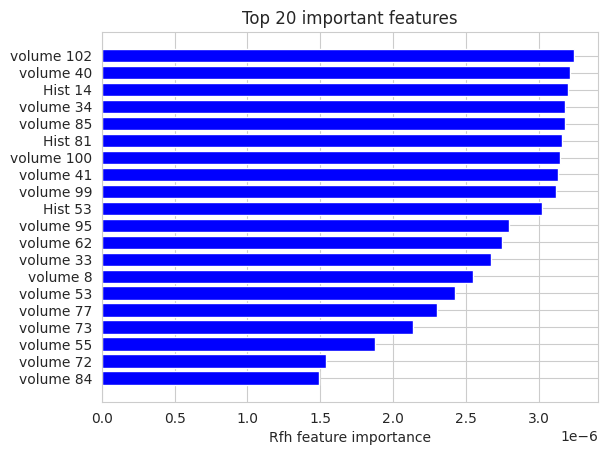

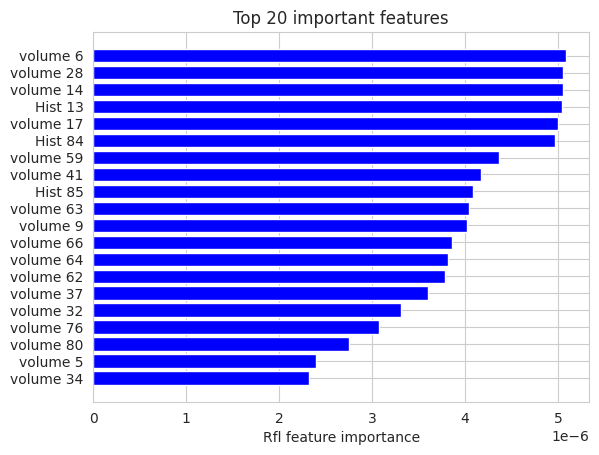

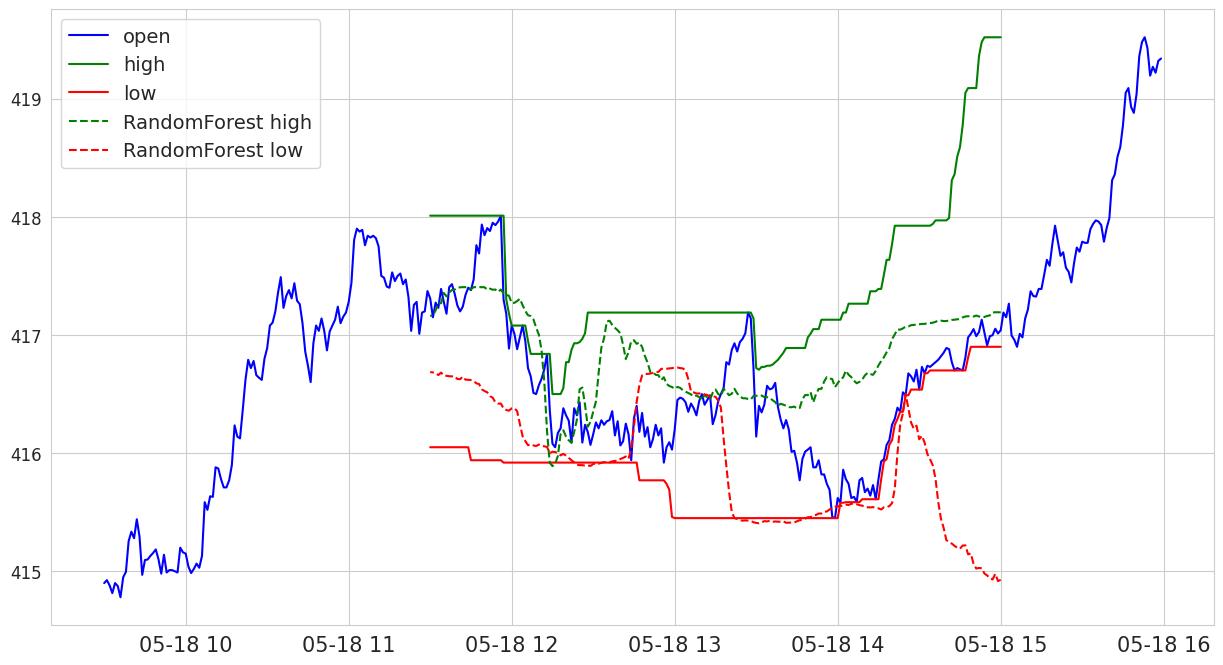

In [ ]:
#Draw RandomForest feature importances and predictions for High/Low
indicesh=np.argsort(rfh.feature_importances_)[:20]
plt.barh(range(20), rfh.feature_importances_[indicesh], color='b', align='center')
plt.yticks(range(20), [X_test.columns[i] for i in indicesh])
plt.xlabel('Rfh feature importance')
plt.title('Top 20 important features')
plt.show()

indicesl=np.argsort(rfl.feature_importances_)[:20]
plt.barh(range(20), rfl.feature_importances_[indicesl], color='b', align='center')
plt.yticks(range(20), [X_test.columns[i] for i in indicesl])
plt.xlabel('Rfl feature importance')
plt.title('Top 20 important features')
plt.show()

plt.figure(figsize=(15,8))
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].open,'b',label='open')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].high,'g',label='high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].low,'r',label='low')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         rfh.predict(X_test),'g--',label='RandomForest high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         rfl.predict(X_test),'r--',label='RandomForest low')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

In [ ]:
#Preprocess the data via MinMaxScaler to use SVR
X_train=pd.read_csv('X_train.csv').copy()
Y_train=pd.read_csv('Y_train.csv').copy()
X_test=pd.read_csv('X_test.csv').copy()
Y_test=pd.read_csv('Y_test.csv').copy()

scaler=MinMaxScaler()
scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [ ]:
#Use SVR model. The parameters are from grid search
svrh=SVR(kernel='rbf', C=5.18, gamma=0.016).fit(X_train_scaled, Y_train['High'])
svr_mae_high=mean_absolute_error(svrh.predict(X_test_scaled),Y_test['High'])

svrl=SVR(kernel='rbf', C=3.76, gamma=0.004).fit(X_train_scaled, Y_train['Low'])
svr_mae_low=mean_absolute_error(svrl.predict(X_test_scaled),Y_test['Low'])

print('MAE_HIGH:',svr_mae_high)
print('MAE_LOW:',svr_mae_low)

MAE_HIGH: 0.6517660619477909
MAE_LOW: 0.41521838054688726


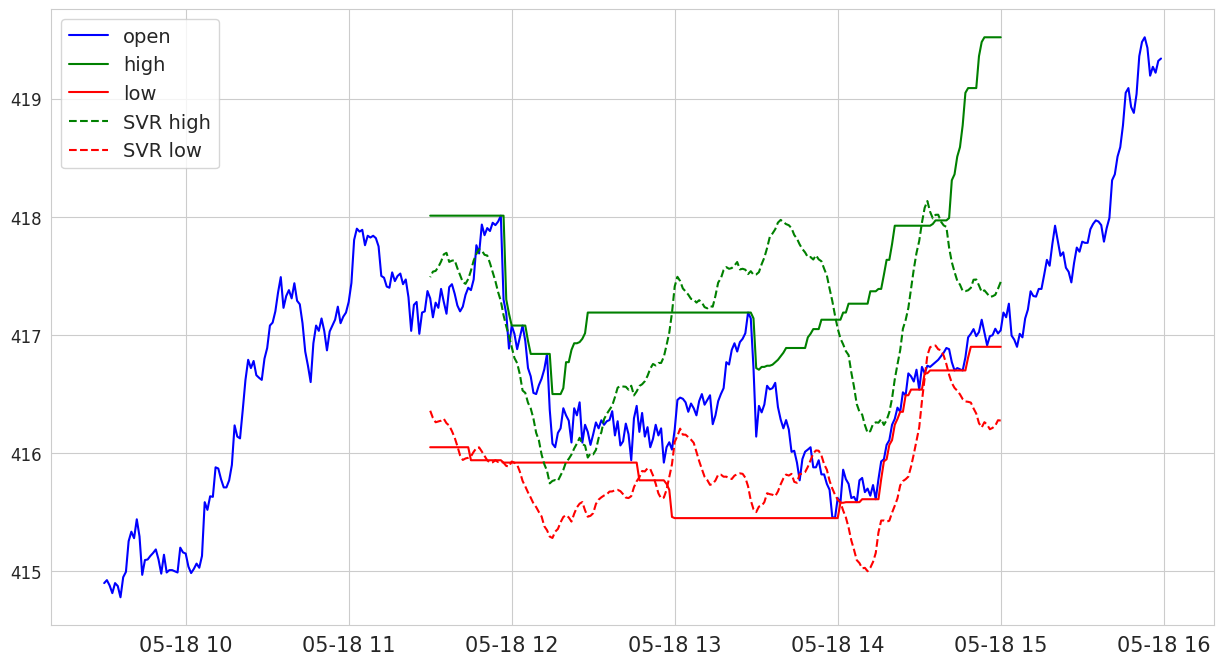

In [ ]:
#Draw SVR predictions for High/Low
plt.figure(figsize=(15,8))
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].open,'b',label='open')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].high,'g',label='high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].low,'r',label='low')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         svrh.predict(X_test_scaled),'g--',label='SVR high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         svrl.predict(X_test_scaled),'r--',label='SVR low')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

In [2]:
#Use XGBoost. The parameters are from grid search
X_train=pd.read_csv('X_train.csv').copy()
Y_train=pd.read_csv('Y_train.csv').copy()
X_test=pd.read_csv('X_test.csv').copy()
Y_test=pd.read_csv('Y_test.csv').copy()

xgbh=xgb.XGBRegressor(objective='reg:absoluteerror', max_depth=2, alpha=0.3,
                        min_child_weight=2,seed=1).fit(X_train, Y_train['High'])
xgbl=xgb.XGBRegressor(objective='reg:absoluteerror', max_depth=2, alpha=0,
                        min_child_weight=5,seed=1).fit(X_train, Y_train['Low'])
xgb_mae_high=mean_absolute_error(xgbh.predict(X_test),Y_test['High'])
xgb_mae_low=mean_absolute_error(xgbl.predict(X_test),Y_test['Low'])

print('MAE_HIGH:',xgb_mae_high)
print('MAE_LOW:',xgb_mae_low)

MAE_HIGH: 0.5858999102117873
MAE_LOW: 0.42129327676059264


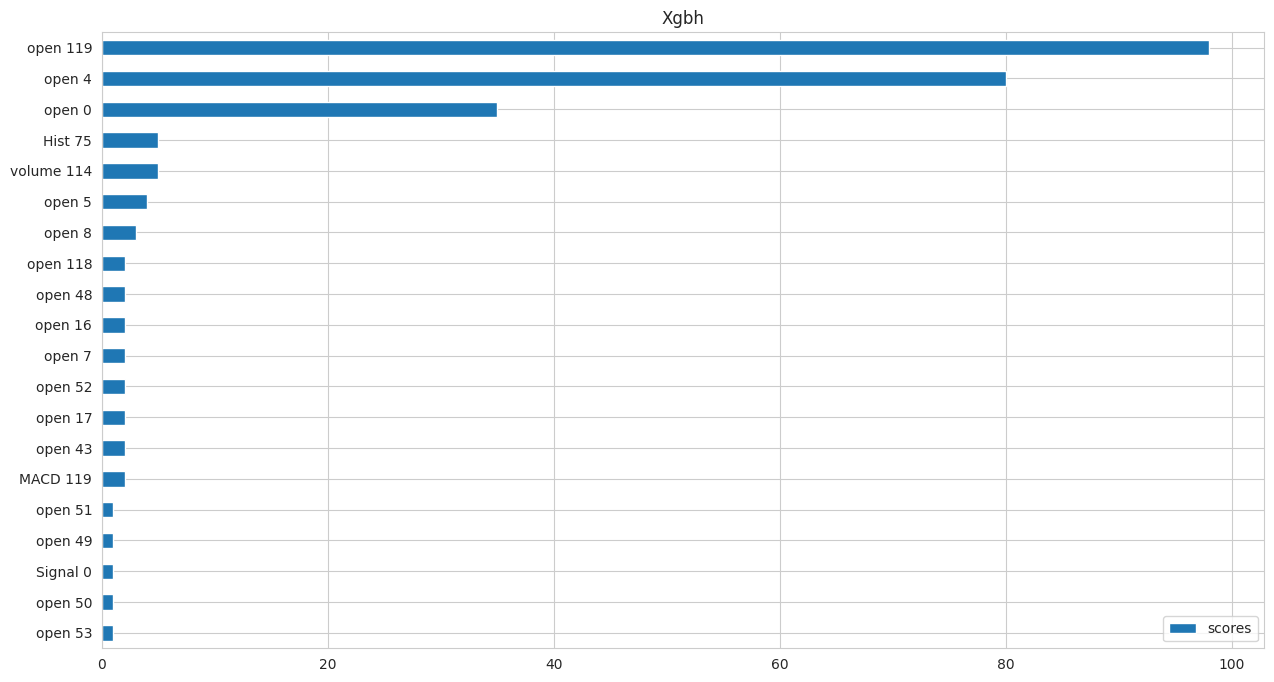

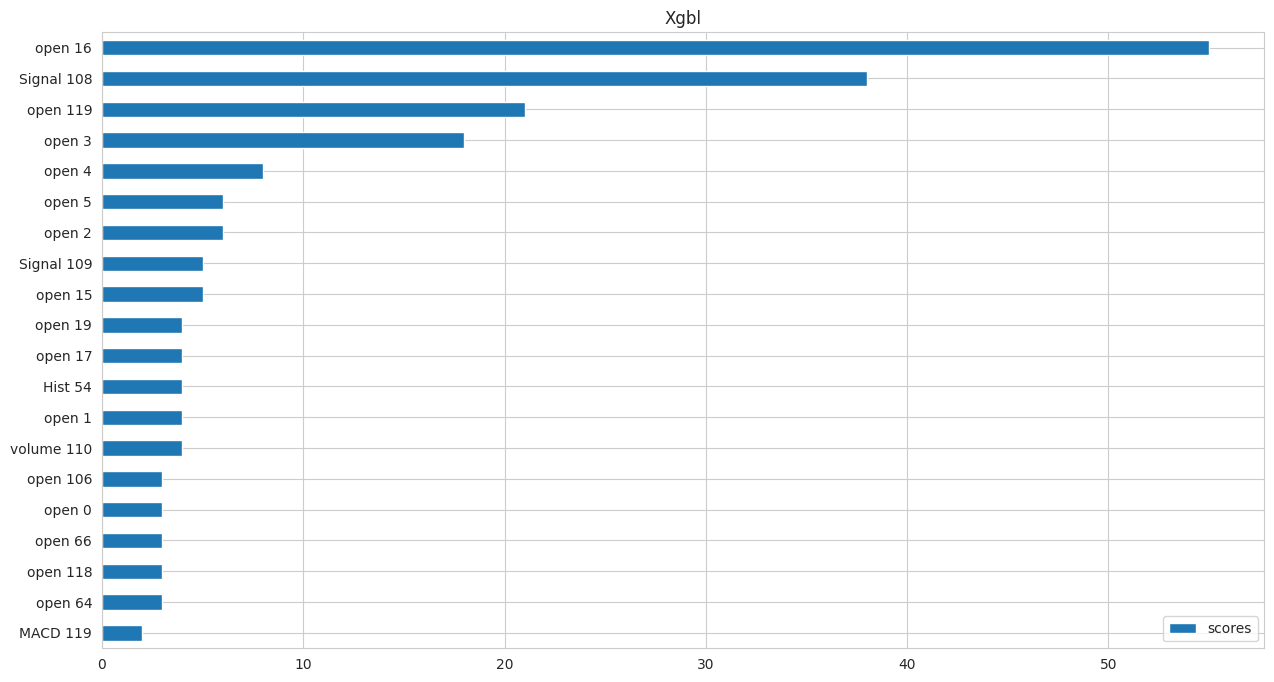

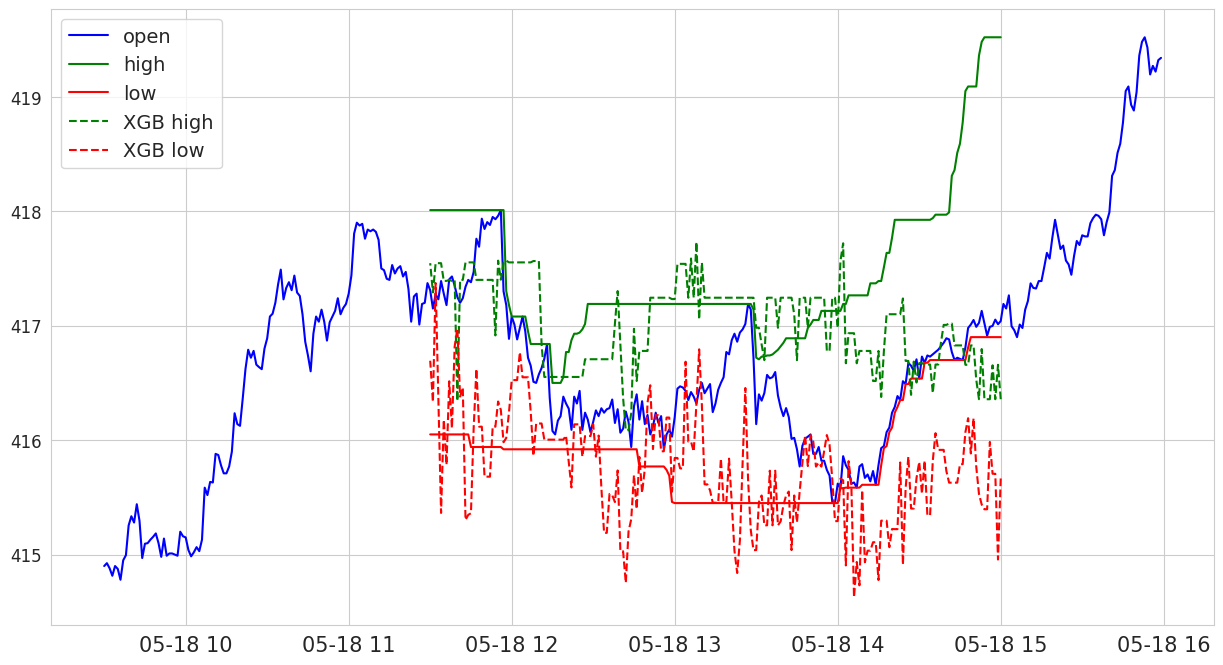

In [ ]:
#Draw XGBoost feature importances and predictions for High/Low
feature_scores_h=xgbh.get_booster().get_score(importance_type='weight')
keys_h=list(feature_scores_h.keys())
values_h=list(feature_scores_h.values())

feature_chart_h=pd.DataFrame(data=values_h, index=keys_h, columns=['scores']).sort_values(by='scores')
feature_chart_h.nlargest(20, columns='scores').sort_values(by='scores', ascending=True).plot(title='Xgbh',kind='barh', figsize=(15,8))

feature_scores_l=xgbl.get_booster().get_score(importance_type='weight')
keys_l=list(feature_scores_l.keys())
values_l=list(feature_scores_l.values())

feature_chart_l=pd.DataFrame(data=values_l, index=keys_l, columns=['scores']).sort_values(by='scores')
feature_chart_l.nlargest(20, columns='scores').sort_values(by='scores', ascending=True).plot(title='Xgbl',kind='barh', figsize=(15,8))

plt.figure(figsize=(15,8))
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].open,'b',label='open')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].high,'g',label='high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].low,'r',label='low')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         xgbh.predict(X_test),'g--',label='XGB high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         xgbl.predict(X_test),'r--',label='XGB low')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

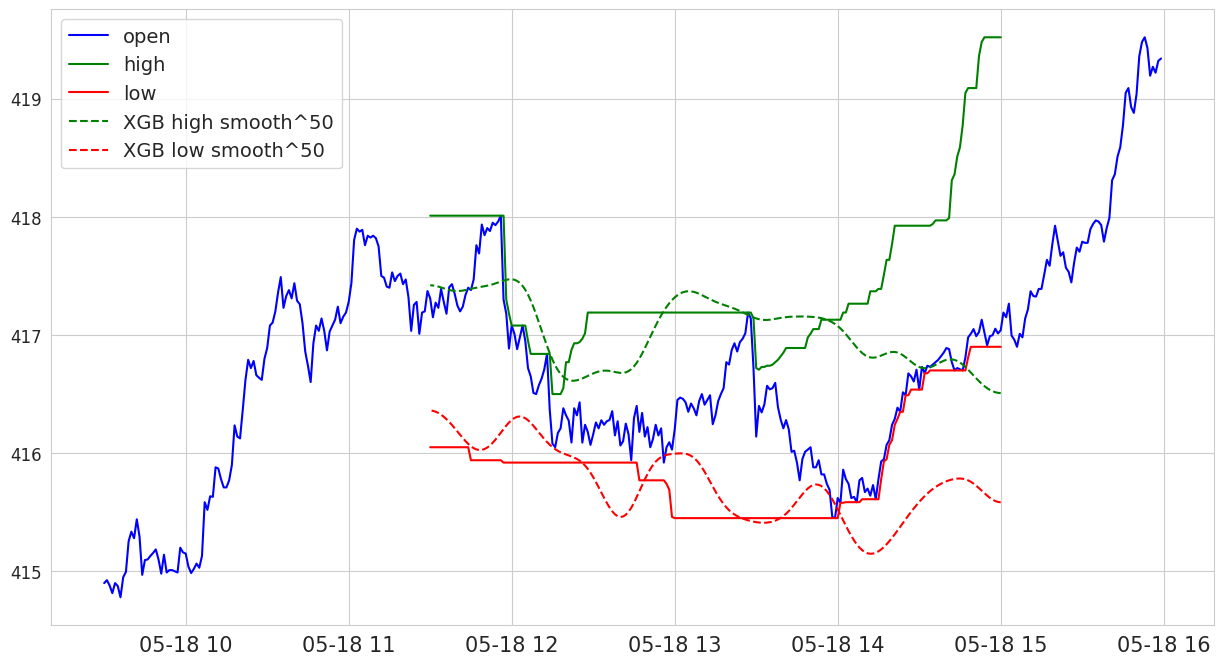

MAE_HIGH_S: 0.5377279418402424
MAE_LOW_S: 0.3644488658862684


In [22]:
#Smooth the XGB predictions
def smooth(array):
  new=np.ndarray((len(array),))
  for i in range(len(array)):
    if i==0:
      new[i]=(array[0]+array[1])/2
    elif i==len(array)-1:
      new[i]=(array[i-1]+array[i])/2
    else:
      new[i]=(array[i-1]+array[i]+array[i+1])/3
  return new

def nsmooth(array,n):
  if n==0: return array
  return nsmooth(smooth(array),n-1)

n=50
smoothpredh=nsmooth(xgbh.predict(X_test),n)
smoothpredl=nsmooth(xgbl.predict(X_test),n)

plt.figure(figsize=(15,8))
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].open,'b',label='open')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].high,'g',label='high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].low,'r',label='low')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         smoothpredh,'g--',label=f'XGB high smooth^{n}')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         smoothpredl,'r--',label=f'XGB low smooth^{n}')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

xgb_mae_high_s=mean_absolute_error(smoothpredh,Y_test['High'])
xgb_mae_low_s=mean_absolute_error(smoothpredl,Y_test['Low'])

print('MAE_HIGH_S:',xgb_mae_high_s)
print('MAE_LOW_S:',xgb_mae_low_s)



In [23]:
#Check the MAE on the training set
smoothtrainh=nsmooth(xgbh.predict(X_train),n)
smoothtrainl=nsmooth(xgbl.predict(X_train),n)
xgb_mae_high_trains=mean_absolute_error(smoothtrainh,Y_train['High'])
xgb_mae_low_trains=mean_absolute_error(smoothtrainl,Y_train['Low'])
print('MAE_HIGH_TS:',xgb_mae_high_trains)
print('MAE_LOW_TS:',xgb_mae_low_trains)

MAE_HIGH_TS: 0.323340879395116
MAE_LOW_TS: 0.25620937406988775
